Utility functions

In [14]:
def prepare_data_for_train(df_wafers,load = False,save = False,path = 'rectangles_r7.pkl.npy',radius = 7):
    wafer_groups = df_wafers.groupby('WaferName')
    wafer_names = df_wafers['WaferName'].unique()

    df_wafers_split = [wafer_groups.get_group(wafer) for wafer in wafer_names]

    wafers_matrix = [wafer_to_matrix(wafer) for wafer in df_wafers_split]
    wafers_label_matrix = [wafer_to_label_matrix(wafer) for wafer in df_wafers_split]
    y = wafers_label_matrix.copy()

    #flatten the matrix to a vector and concatenate all the vectors into a single vector
    y_flat = [y_i.flatten() for y_i in y]
    y_flat = np.concatenate(y_flat)
    y_flat = y_flat.astype(np.int8)

    if load:
        rectangles = np.load(path)
    else:
        rectangles = extract_rectangles(wafers_matrix, radius)

    if save:
        np.save(path,rectangles)

    return rectangles,y_flat


# take each wafer and convert it to a matrix with the same dimensions as the original image where each pixel is 0 or 1 depending on whether it is IsGoodDie or not
def wafer_to_matrix(wafer):
    # wafer_matrix = np.zeros((wafer['DieX'].max()+1, wafer['DieY'].max()+1))
    # create an array of the same size as the wafer matrix but with the data type int8 and -1 as the default value
    wafer_matrix = np.full((wafer['DieX'].max()+1, wafer['DieY'].max()+1), -1, dtype=np.int8)
    wafer_matrix = np.array(wafer_matrix, dtype=np.int8)
    die_x = wafer['DieX'].values 
    die_y = wafer['DieY'].values 
    is_good_die = wafer['IsGoodDie'].values
    wafer_matrix[die_x, die_y] = is_good_die
    return wafer_matrix


# y is the IsScratchDie for each die in the wafer if the (x,y) is in the wafer then the label is taken from the IsScratchDie column otherwise it is 0

def wafer_to_label_matrix(wafer):
    wafer_matrix = np.zeros((wafer['DieX'].max()+1, wafer['DieY'].max()+1))
    die_x = wafer['DieX'].values 
    die_y = wafer['DieY'].values 
    is_scratch_die = wafer['IsScratchDie'].values
    wafer_matrix[die_x, die_y] = is_scratch_die.astype(np.int8)
    return wafer_matrix


from tqdm import tqdm

def extract_rectangles(matrix_list, A):
    all_rectangles = []
    for matrix in tqdm(matrix_list):
        
        padded_matrix = np.pad(matrix, pad_width=((A // 2, A // 2), (A // 2, A // 2)), mode='constant', constant_values=0)
        rows, cols = matrix.shape
        shape = (rows, cols, A, A)
        strides = padded_matrix.strides + padded_matrix.strides
        window_view = np.lib.stride_tricks.as_strided(padded_matrix, shape=shape, strides=strides)
        flattened_windows = window_view.reshape((-1, A*A)).astype(np.int8)
        all_rectangles.extend(flattened_windows.tolist())
    return all_rectangles


import numpy as np
from collections import Counter

def under_sample(X, y):
    # assuming X is your feature matrix and y is your target variable
    # where y is 0.02 for the minority class and 0 for the majority class

    # get indices of minority and majority class samples
    minority_indices = np.where(y == 1)[0]
    majority_indices = np.where(y == 0)[0]

    # determine size of minority class
    minority_size = len(minority_indices)

    # randomly sample majority class
    random_majority_indices = np.random.choice(majority_indices, minority_size, replace=False)

    # concatenate minority class indices with randomly sampled majority class indices
    undersampled_indices = np.concatenate([minority_indices, random_majority_indices])

    # extract undersampled feature matrix and target variable
    X_undersampled = X[undersampled_indices, :]
    y_undersampled = y[undersampled_indices]

    return X_undersampled, y_undersampled


def train_model(X,y):
    from sklearn.model_selection import train_test_split
    import lightgbm as lgb
    from sklearn.metrics import accuracy_score


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    X_train = np.array(X_train).astype(np.int8)
    y_train = np.array(y_train).astype(np.int8)

    X_train, y_train = under_sample(X_train, y_train)
    
    d_train = lgb.Dataset(X_train, label=y_train)
    d_test = lgb.Dataset(X_test, label=y_test)

    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'num_leaves': 31,
        'learning_rate': 0.1,
        'max_depth': -1,
        'min_child_samples': 20,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5
    }

    clf = lgb.train(params, d_train, 100)

    y_pred=clf.predict(X_test)

    y_pred[y_pred>=0.5] = 1
    y_pred[y_pred<0.5] = 0

    print('Accuracy: ', accuracy_score(y_test, y_pred))

    return y_test, y_pred, clf

def test_model(clf,df_wafers_test,radius = 7):
    wafer_groups_test = df_wafers_test.groupby('WaferName')
    wafer_names_test = df_wafers_test['WaferName'].unique()

    df_wafers_split_test = [wafer_groups_test.get_group(wafer) for wafer in wafer_names_test]
    test_matrixs = [wafer_to_matrix(wafer) for wafer in df_wafers_split_test]

    test_rectangles = extract_rectangles(test_matrixs,radius)

    test_predictions = clf.predict(test_rectangles)

    test_predictions [test_predictions>0.5] = 1
    test_predictions [test_predictions<=0.5] = 0

    trimmed_predictions = remove_non_die_predictions(test_predictions,test_rectangles)


    return trimmed_predictions



def plt_confusion_matrix(y_test, y_pred):
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


def trim_edges(predictions,origin):

    trimmed_predictions =  predictions.copy()

    for i in range(len(predictions)):
        dim = predictions[i].shape
        # dim is (n,n) create array of (x,y) coordinates of the n*n grid
        coords = np.array(np.meshgrid(range(dim[0]), range(dim[1]))).T.reshape(-1,2)
        for coord in coords:
            # if the example[i] has (DieX, DieY) coordinates equal to the coord then keep the prediction else set it to -1
            if not any((origin[i]['DieX'] == coord[0]) & (origin[i]['DieY'] == coord[1])):
                trimmed_predictions[i][coord[0]][coord[1]] = -1


    return trimmed_predictions


def remove_non_die_predictions(predictions,origin):
    #if at test_rectangles[i][24] (the center of the rectangle) the val is -1 then remove the prediction
    trimmed_predictions =  []
    for i in range(len(predictions)):
        if origin[i][24] != -1:
            trimmed_predictions.append(predictions[i])
    return trimmed_predictions



MAIN code

In [6]:
import pandas as pd
import zipfile

print('Loading data...')
#load zip file
zf = zipfile.ZipFile('data.zip') 
#load train data
df_wafers = pd.read_csv(zf.open('df_wafers.csv'))

#load test data
df_wafers_test = pd.read_csv(zf.open('df_wafers_test.csv'))

Loading data...


In [7]:
radius = 7
print('Preparing data...')
X,y = prepare_data_for_train(df_wafers,radius = radius)

Preparing data...


100%|██████████| 3920/3920 [00:59<00:00, 65.35it/s] 


Training model...
[LightGBM] [Info] Number of positive: 70793, number of negative: 70793
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 147
[LightGBM] [Info] Number of data points in the train set: 141586, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Accuracy:  0.931610591234415


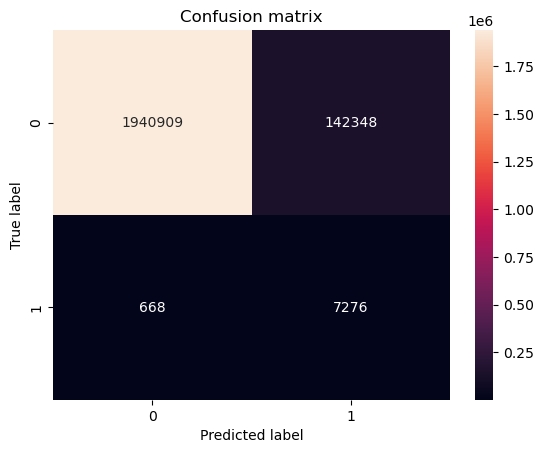

In [15]:
print('Training model...')
y_test, y_pred, clf = train_model(X,y)

plt_confusion_matrix(y_test, y_pred)

In [16]:
print('Testing model...')
predictions = test_model(clf,df_wafers_test,radius = radius)

#save predictions
df_predictions = pd.DataFrame(predictions)

Testing model...


100%|██████████| 439/439 [00:21<00:00, 20.46it/s] 


In [19]:
df_predictions.to_csv('predictions.csv',index=False)